In [4]:
import skimage as sk
from skimage.io import imread, imshow, imsave
import numpy as np
import os
from glob import glob
import napari
import pyclesperanto as cle
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
cle.select_device("NVIDIA")

(OpenCL) NVIDIA RTX A4000 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              572.83
	Device Type:                 GPU
	Compute Units:               48
	Global Memory Size:          16375 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         4093 MB
	Max Clock Frequency:         1560 MHz
	Image Support:               Yes

### Reading in images

In [6]:
#set voxel size for images
voxel_size_x = 0.301
voxel_size_y = 0.301
voxel_size_z = 4.55
voxels = [voxel_size_z, voxel_size_y, voxel_size_x]

In [53]:
CMO_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/Control_MO/*.tif'))
GMO_1ng_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/GNAS_MO_1ng/*.tif'))
GMO_2ng_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/GNAS_MO_2ng/*.tif'))

In [54]:
CMO_imgs = list(map(sk.io.imread,CMO_files))
GMO_1ng_imgs = list(map(sk.io.imread,GMO_1ng_files))
GMO_2ng_imgs = list(map(sk.io.imread,GMO_2ng_files))

In [ ]:
viewer = napari.view_image(GMO_1ng_imgs[1], name= 'test', scale = voxels)

## Plan: preprocess, threshold signal, connected components, post-process objects, measure volume and SA to get ratio, measure fluorescence values, PCA on volume/SA to find threshold for splitting into active and inactive state?

#### Trying to get GPU use working

In [69]:
test_img = CMO_imgs[6]

array([[[105, 107, 108, ..., 109,  94, 104],
        [103, 104, 110, ..., 109, 114, 104],
        [101,  97,  99, ..., 105, 101, 106],
        ...,
        [103, 102, 112, ..., 102,  99, 101],
        [102, 106, 103, ..., 115, 106, 113],
        [105, 106, 107, ..., 107, 106, 117]],

       [[105, 103, 101, ..., 101,  95, 102],
        [106, 106, 103, ..., 106, 105, 107],
        [117, 103, 108, ..., 104, 100, 106],
        ...,
        [104, 105, 106, ..., 102, 106,  97],
        [108, 106,  99, ..., 102, 101, 109],
        [116, 116, 106, ..., 108, 111, 107]],

       [[106, 107, 104, ..., 102, 101, 100],
        [107, 104, 100, ..., 106,  96, 102],
        [102,  98, 106, ..., 110, 104, 109],
        ...,
        [104, 103, 108, ..., 110, 110, 106],
        [105, 106, 105, ..., 105, 108, 109],
        [101, 106, 109, ..., 107, 118, 112]],

       ...,

       [[104, 107, 100, ..., 109, 106, 106],
        [102, 103, 101, ..., 108, 105, 107],
        [100, 101, 107, ..., 110, 106, 105],
        ...,
        [109, 102, 101, ..., 103, 104, 100],
        [110, 103, 100, ..., 105, 106, 104],
        [107, 109, 102, ..., 104, 110, 107]],

       [[103, 106, 101, ..., 103, 112, 110],
        [104, 100, 100, ..., 112, 106, 112],
        [108, 100, 104, ..., 115, 110, 109],
        ...,
        [104, 102, 110, ..., 104, 105,  99],
        [103, 103, 103, ..., 107, 103, 111],
        [ 94, 103, 106, ..., 114, 108, 107]],

       [[106, 106, 103, ..., 100, 104, 103],
        [103, 109, 103, ..., 110, 108, 113],
        [105, 101, 103, ..., 111, 109, 111],
        ...,
        [106, 104, 101, ..., 101, 100, 105],
        [105, 103, 104, ..., 110, 105, 114],
        [ 92, 105, 107, ..., 111, 108, 116]]], dtype=uint16, mtype=buffer)
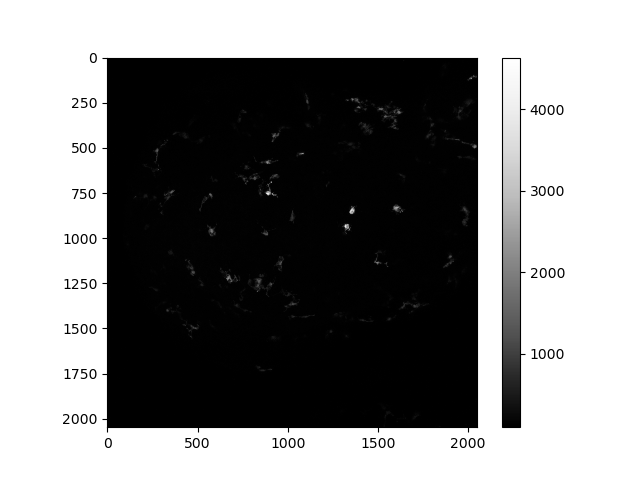
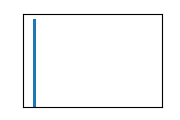

In [70]:
input_gpu = cle.push(test_img)
input_gpu

Inspect 3D data

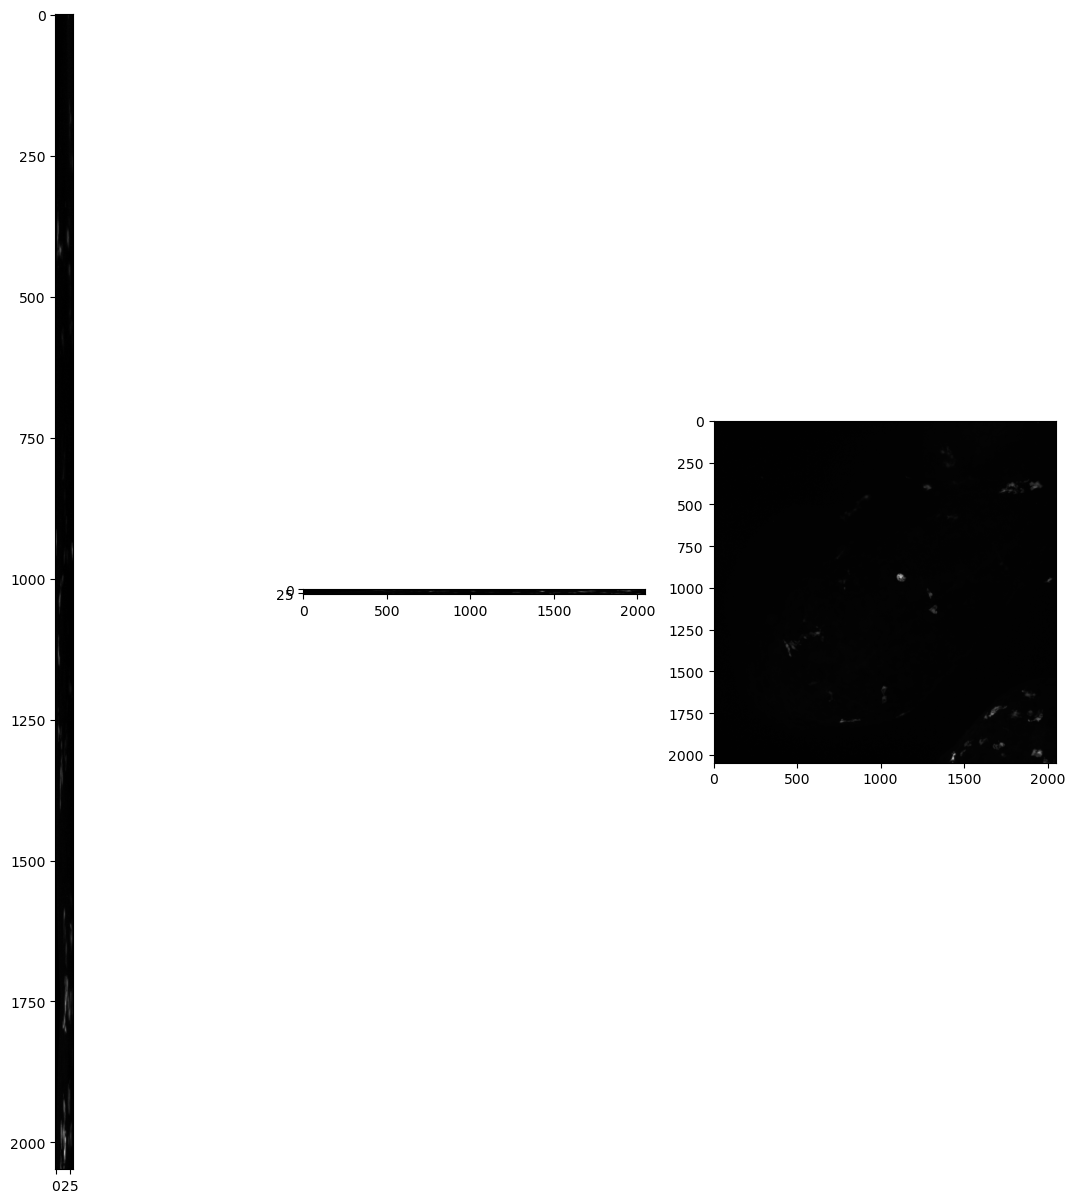

(31, 2048, 2048)


In [59]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(projection_x, cmap='prism' if labels else 'gray')
    axs[1].imshow(projection_y, cmap='prism' if labels else 'gray')
    axs[2].imshow(projection_z, cmap='prism' if labels else 'gray')
    plt.show()

show(input_gpu)
print(input_gpu.shape)

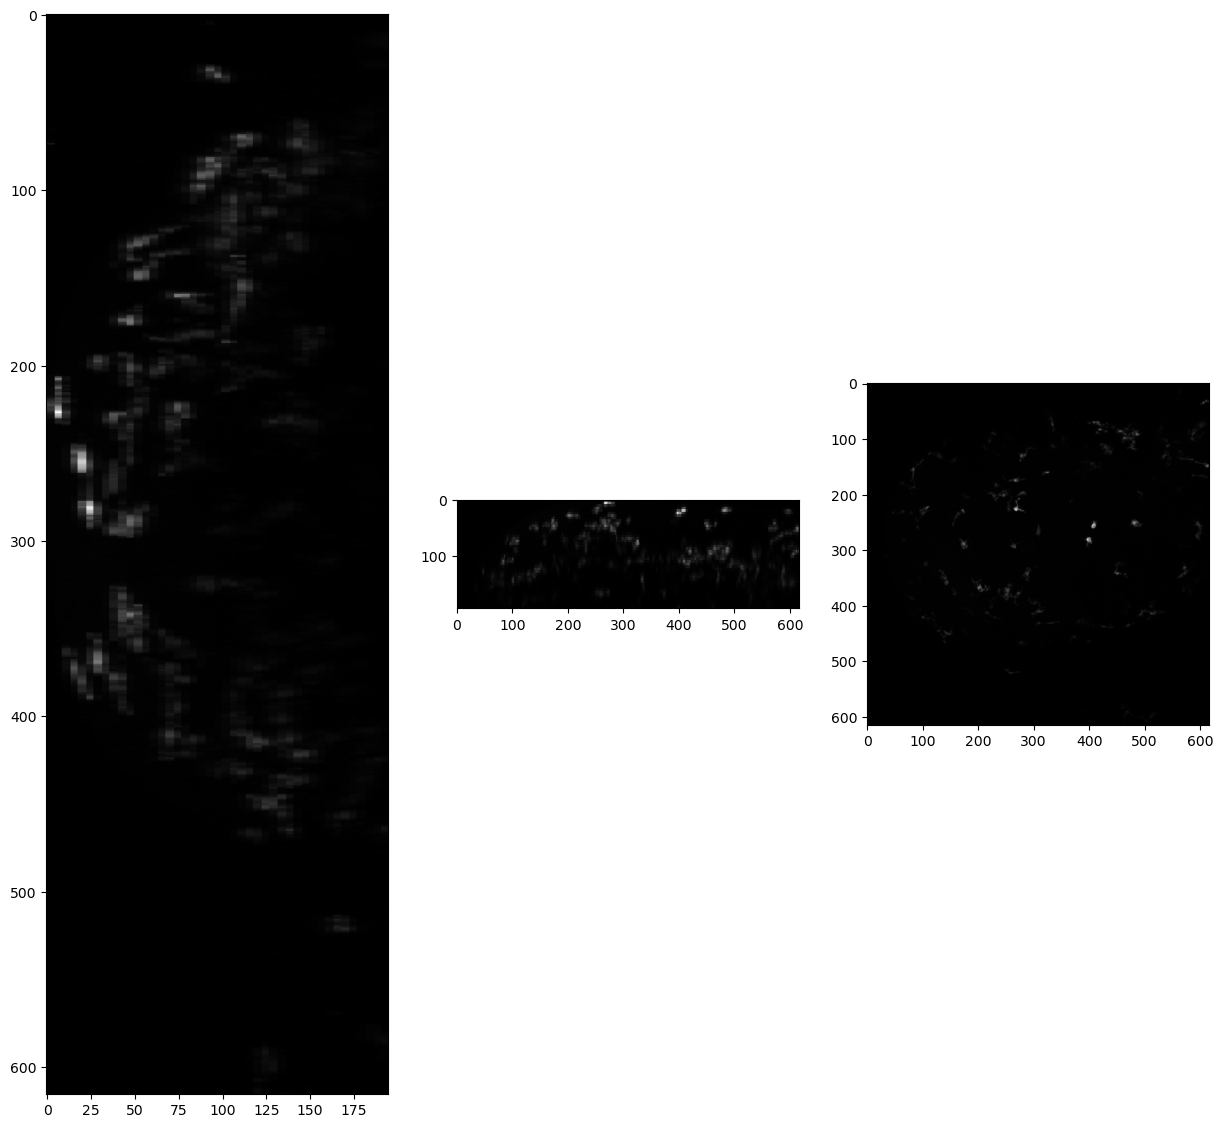

(195, 616, 616)


In [71]:
#Resample to make isotropic
resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)

show(resampled)
print(resampled.shape)

May not have enough Z resolution for resonable reasults

In [72]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[2]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # get a single slice out of the stack
    cle.copy_slice(resampled, a_slice, z)
    # measure its intensity
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

#show(equalized_intensities_stack)

In [73]:
#Correct background
background_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=10, radius_y=10, radius_z=10)
#show(background_subtracted)

In [ ]:
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=5, outline_sigma=2)
show(segmented, labels=True)

In [ ]:
help(cle.detect_maxima_box)

In [74]:
sigma_spot_detection = 7
blurred = cle.gaussian_blur(background_subtracted, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)
#enough of a blue to remove most of the texture of the objects wihle retaining their presence

detected_spots = cle.detect_maxima_box(blurred, radius_x=1, radius_y=1, radius_z=1)

number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("number of detected spots", number_of_spots)
#viewer = napari.view_image(blurred, name='blurred')
#viewer.add_image(detected_spots, name='spots')
# fig, axs = plt.subplots(1, 2, figsize=(15, 15))
# axs[0].imshow(blurred[95,300:500,300:])
# axs[1].imshow(detected_spots[95,300:500,300:])
# plt.show()

number of detected spots 1064.0


In [75]:
sigma_outline = 1
blurred = cle.gaussian_blur(background_subtracted, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
#Smaller blur to make threhsolding easier and maintain reasonable boundaries

# binary = cle.threshold_otsu(blurred)
# viewer = napari.view_image(blurred, name='blurred')
# viewer.add_image(binary, name='mask')

In [76]:
copy_blurred = cle.copy(blurred)
copy_background_subtracted = cle.copy(background_subtracted)

In [ ]:
help(cle.greater)

In [77]:
blurred_cpu = cle.pull(copy_blurred)
iso_norm = cle.pull(copy_background_subtracted)

In [78]:
#testing thresholds

thresh = sk.filters.threshold_multiotsu(blurred_cpu, classes=5)
print(thresh)
mask = blurred>thresh[1]

# viewer = napari.view_image(blurred, name='blurred')
# viewer.add_image(mask, name='mask')
# viewer.add_image(iso_norm, name='iso data')

[  57.952507  203.85278   507.81168  1225.1545  ]


In [80]:
viewer = napari.view_image(iso_norm, name='iso data')
viewer.add_image(blurred, name='blurred')
viewer.add_image(mask, name='mask')

<Image layer 'mask' at 0x2178c760e50>

In [82]:
mask_gpu = blurred > thresh[1]
viewer = napari.view_image(mask_gpu, name='mask')

In [83]:
selected_spots = cle.binary_and(mask_gpu, detected_spots)

number_of_spots = cle.sum_of_all_pixels(selected_spots)
print("number of selected spots", number_of_spots)

viewer = napari.view_image(mask_gpu, name='mask')
viewer.add_image(detected_spots, name='Original Spots')
viewer.add_image(selected_spots, name='Filtered Spots')

number of selected spots 60.0


<Image layer 'Filtered Spots' at 0x217ee2efd00>

In [85]:
voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, mask_gpu)
viewer = napari.view_image(voronoi_diagram, name='mask')
viewer.add_image(background_subtracted, name='blurred_img')

<Image layer 'blurred_img' at 0x217f23cf100>

In [87]:
import pandas as pd

In [88]:
df = pd.DataFrame(
    cle.statistics_of_labelled_pixels(resampled, voronoi_diagram)
    )
df.head()
df.to_csv(os.path.join(save_df_path,'measurements_'+clean_name+'.csv'))

,sum_z,label,sum_intensity_times_z,bbox_min_x,bbox_min_y,sum_intensity_times_x,bbox_depth,bbox_min_z,bbox_max_x,bbox_max_y,...,centroid_z,sum_distance_to_centroid,mean_distance_to_centroid,sum_distance_to_mass_center,mean_distance_to_mass_center,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio
0,12580.0,1.0,9482670.0,262.0,206.0,406784160.0,15.0,0.0,284.0,233.0,...,6.402036,14913.187500,7.589408,14822.982422,7.543502,725.713562,18.461147,19.064056,2.432488,2.527215
1,38310.0,2.0,19386086.0,244.0,362.0,272656416.0,19.0,9.0,260.0,391.0,...,18.122044,16549.730469,7.828633,16574.974609,7.840575,246.587280,18.612383,18.298662,2.377475,2.333842
2,37916.0,3.0,26975614.0,475.0,245.0,675435648.0,14.0,13.0,494.0,259.0,...,19.305500,12180.506836,6.201888,12197.854492,6.210721,511.122986,11.624782,12.150910,1.874394,1.956441
3,32056.0,4.0,30724140.0,403.0,247.0,637371392.0,17.0,12.0,413.0,262.0,...,19.594133,9354.590820,5.717965,9366.549805,5.725275,858.965332,9.540623,9.830565,1.668535,1.717047
4,33650.0,5.0,16009222.0,590.0,249.0,425981440.0,11.0,17.0,603.0,281.0,...,22.493317,14061.109375,9.399137,13957.680664,9.330001,173.100754,19.374603,19.995184,2.061317,2.143106


In [ ]:
def segment_on_GPU(input_image,spot_sigma,outline_sigma,voxel_size_z,voxel_size_y,voxel_size_x):
    img_gpu = cle.push(input_image)
    resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
    cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)
    #normalize the image stack
    equalized_intensities_stack = cle.create_like(resampled)
    a_slice = cle.create([resampled.shape[1], resampled.shape[2]])
    num_slices = resampled.shape[0]
    mean_intensity_stack = cle.mean_of_all_pixels(resampled)
    corrected_slice = None
    for z in range(0, num_slices):
        # get a single slice out of the stack
        cle.copy_slice(resampled, a_slice, z)
        # measure its intensity
        mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
        # correct the intensity
        correction_factor = mean_intensity_slice/mean_intensity_stack
        corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
        # copy slice back in a stack
        cle.copy_slice(corrected_slice, equalized_intensities_stack, z)
    #background subtraction
    background_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=10, radius_y=10, radius_z=10)
    #get seed points
    blurred = cle.gaussian_blur(background_subtracted, sigma_x=spot_sigma, sigma_y=spot_sigma, sigma_z=spot_sigma)
    detected_spots = cle.detect_maxima_box(blurred, radius_x=1, radius_y=1, radius_z=1)
    #segment signal
    blurred = cle.gaussian_blur(background_subtracted, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
    copy_blurred = cle.copy(blurred)
    blurred_cpu = cle.pull(copy_blurred)
    thresh = sk.filters.threshold_multiotsu(blurred_cpu, classes=5)
    mask = blurred > thresh[1]
    selected_spots = cle.binary_and(mask_gpu, detected_spots)
    voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, mask_gpu)